# CHAPTER 03. 평가
성능 평가 지표(Evaluation Metric) : 일반적으로 모델이 회귀냐에 따라 여러 종류로 나뉜다. 
- 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반한다. 기본적으로 예측 오차를 가지고 정규화 수준을 재 가공하는 방법하는 방법이 회귀의 성능 평가 지표 유형이다..
- 분류 성능 평가 지표
    - 정확도(Accuracy)
    - 오차행렬(Confusion Matrix)
    - 정밀도(Precision)
    - 재현율(Recall)
    - F1 스코어
    - ROC AUC
- 분류는 결정 클래스 값 종류이 유형에 따라 2개의 결괏값만을 가지는 이진 분류와 여러개의 결정 클래스 값을 가지는 멀티분류로 나뉠 수 있다.

## 01. 정확도(Accuracy)
: 실제 데이터에서 예측에티어가 얼마나 같은지를 판단하는 지표
- 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
- 직관적으로 모델 예측 성능을 나타내는 평가 지표이다. 하지만 이진분류의 경우 데이터 구성에 따라 ML 모델 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하기 어렵다.

- BaseEstimator을 상속받으면 Customized 형태의 Estimator를 개발자가 생성할 수 있다.

In [16]:
# 정확도 지표가 어떻게 ML 모델 성능을 왜곡하는지 알아보기
# BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit()메서드는 아무 것도 학습하지 않는다.
    def fit(self, X, y=None):
        pass
    # predict()메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]) :
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1
                
        return pred

In [17]:
# 2장에서 만든 함수 가져오기

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1] # 방 첫번째 알파벳 추출
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features :
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [18]:
# MyDummyClassifier를 이용해 타이타닉 생존자 예측 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/Users/wizdom/Desktop/data_analysis/Kaggle_titanic/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


이렇게 단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도의 결과는 78%로 높은 수치가 나올 수 있기에 정확도를 평가지표로 사용할 때는 매우 신중해야한다. 특히 정확도는 불균한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

In [19]:
# load_digits() API를 통해 MINIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용시 어떤 문제가 발생할 수 있는지 살펴보자
# 레이블 값이 0부터 9까지 있는 멀티 레이블 분류가 되어있는 것을 레이블 값이 7인 것만 True, 나머지는 모두 Flase로 변환해 이진 분류문제로 바꾼다.
# 즉, 전체 데이터의 10% TRUE, 나머지 90%는 False인 불균형한 데이터 세트로 변형
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [20]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기: ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도:\n',pd.Series(y_test).value_counts())

# Dummy Classfier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기:  (450,)
테스트 세트 레이블 0과 1의 분포도:
 0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안된다.
- 이러한 한계점을 극복하기 위해 여러가지 분류 지표와 함께 사용해야한다.

## 02. 오차 행렬
: 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여준다. 즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표이다. 
- 이진 분류에서 성능지표로 잘 활용된다.
- 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타낸다.
    - TN, FP, FN, TP는 예측 클래스와 실제 클래스의 Positive 결정값(값 1)과 Negative 결정 값(값 0)의 결합에 따라 결정된다.
    - 4분면의 왼쪽, 오른쪽을 예측된 클래스 값 기준으로 Negative와 Positive로 분류
    - 4분면의 위, 아래를 실제 클래스값 기준으로 Negative와 Positive로 분류
    - 그럼 예측 클래스와 실제 클래스 값 유혀엥 따라 결정되는 TN, FP, FN, TP 형태로 오차 행렬의 4분면을 채운다.
    - 4가지를 다양하게 결합해 분류 모델 예측 성능의 오류가 어떠한 모습으로 발생하는지 알 수 있다. 
- TN, FP, FN, TP
    - TN : 예측 값을 Negative 값 0으로 예측했고, 실제 값 역시 Negative 값 0
    - FP : 예측 값을 Positive 값 1로 예측했는데, 실제 값은 Negative 값 0
    - FN : 예측 값을 Negative 값 0으로 예측했는데, 실제 값은 Positive 값 1
    - TP : 예측 값을 Positive 값 1로 예측했는데, 실제 값 역시 Positive 값 1

- 오차행렬을 구하기 위한 API : confusion_matrix()

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

In [16]:
# 출력된 오차 행렬은 ndarray 형태
# TN : [0, 0]로 405, FP: [0, 1]로 0, FN : [1, 0]로 45, TP: [1, 1]로 0

- TP, TN, FP, TN 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보를 제공한다.
- 이 값들을 조합해 분류 성능을 측정할 수 있는 주요 지표인 정확도, 정밀도, 재현율 값을 알 수 있다.
- 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수  = (TN + TP)/(TN + FP + FN + TP)
    - 오차 행렬에서 True에 해당하는 값인 TN과 TP에 좌우된다.

- 일반적으로 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 중점적으로 찾아야 하는 매우 적은 수의 결괏값에 Positive를 설정해 1값을 부여하고, 그렇지 않은 경우는 Negative로 0 값을 부여하는 경우가 많다.
    - 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘 Positive보다는 Negative로 예측 정확도가 높아지는 경향이 발생(9,990건이 Negative이고 100건이 Positive라면 N으로 예측하는 경향이 더 강해서 TN은 매우 커지고 TP는 매우 작아지게 된다.
    - N으로 예측할 때 정확도가 높기 때문에 FN이 매우 작고, P로 예측하는 경우가 작기 때문에 FP 역시 매우 작아진다.
    - 결과적으로 정확도 지표는 비대칭한 데이터 세트에서 P에 대한 예측 정확도를 판단하지 못한 채 N에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단
  

- 정확도 분류 모델의 성능을 측정할 수 있는 한 가지 요소일 뿐이다.

## 03. 정밀도와 재현율
: Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.
- 정밀도 : "예측"을 Positive로 한 대상 중에 에측과 실제 값이 Positive로 일치한 데이터의 비율.
    - TP / (FP + TP)
    - 공식의 분모인 FP + TP는 예측을 Positive로 한 모든 데이터 건수이며, 공식의 분자인 TP는 예측 값과 실제 값이 Positive로 일치한 데이터 건수이다.
    - Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고도 불린다.
- 재현율 : "실제 값"이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
    - TP / (FP + TP)
    - 공식의 분모인 FN + TP는 실제 값이 Positive인 모든 데이터 건수이며, 공식의 분자인 TP는 예측과 실제 값이 Positive로 일치한 데이터 건수이다.
    - 민감도(Sensitive) 또는 TPR(True positive Rate)라고 불린다.
    
    
- 정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라서 특정 평가 지표가 더 중요한 지표로 간주될 수 있다. 
    - 재현율이 상대적으로 더 중요한 지표인 경우는, 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우이다.
        - 예) 실제 P인 암환자를 P 양성이 아닌 N 음성으로 잘못 판단 했을 경우, 실제 금융거래 사기인 P 건을 N로 잘못 판단한 경우
    - 정밀도가 상대적으로 더 중요한 지표인 경우는, 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우이다.
    - 재현율과 정밀도 모두 TP를 높이는데 동일하게 초점을 맞추지만,
        - 재현율은 FN(실제 P, 예측 N)를 낮추는 데,
        - 정밀도는 FP(실제 N, 예측 P)를 낮추는 데 초점을 맞춘다.
        
        
- 이같은 특성떄문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 적용된다.
    - 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다.
    - 반면에 둘 주 ㅇ어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.

- precision_score( ) : 정밀도 계산을 위한 API
- recall_score( ) : 재현율 계산을 위한 API

In [31]:
# 오차 행렬 및 정밀도, 재현율 모두 구해 예측 성능 평가.
from sklearn. metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 평가 한꺼번에 호출하는 함수 만들기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [34]:
# 로지스틱 회귀 기반으로 생존자 예측 및 평가 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/Users/wizdom/Desktop/data_analysis/Kaggle_titanic/titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
 [[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드오프
- 정밀도 또는 재현율이 특별히 강조돼야 할 경우, 분류의 결정 입곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 
    - 하지만 정밀도와 재현율은 상호 보완적인 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다.
    - 이를 정밀도/재현율의 트레이드 오프라고 부른다.

- predict_proba( ) : 개별 데이터별로 예측 확률을 반환하는 메서드
    - 학습이 완료된 사이킷런 Classifier 객채에서 호출이 가능하며 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환한다.
        - 개별 클래스의 예측 확률을 ndarray m x n(m: 입력 값의 레코드 수, n: 클래스 값 유형) 형태로 반환
        - 각 열은 개별 클래스의 예측 확률이다. 이진분류에서 첫번째 칼럼은 0 Negative의 확률. 두번째 칼럼은 1 Positive의 확률이다.
    - predict( )메서드와 유사하지만 단지 반환 결과가 예측 결과 클래스값이 아닌 예측 확률 결과이다.

In [36]:
# 바로 앞 타이타닉 생존자 데이터를 학습한 LogisticRegression 객체에서 predict_proba()메서드를 수행한 뒤 반환값 확인하고 predict결과와 비교

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
: [[0.46184106 0.53815894]
 [0.87866995 0.12133005]
 [0.8771695  0.1228305 ]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46184106 0.53815894 1.        ]
 [0.87866995 0.12133005 0.        ]
 [0.8771695  0.1228305  0.        ]]


- predict( ) 메서드는 predict_proba()메서드에 기반해 생성된 API이다. 
    - predict_proba() 호출 결과로 반환된 확률 값을 가진 배열에서 분류 결정 임계값(정해진 임곗값)보다 큰 값이 들어있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API이다.
    - 구현을 위해 Binarizer 클래스를 이용한다.
        - Binarizer 객체의 fit_transform() 메서드를 이용해 넘파이 ndarray를 입력하면 입력된 ndarray의 값을 짖어된 threshold보다 같거나 작으면 0값으로, 크면 1값으로 변환해 반환한다.
- 사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있다.


In [39]:
# 예제) threshold 변수를 특정 값으로 설정하고 Binarizer 클래스를 객체로 생성

from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0, 크면 1 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [42]:
# Binarizier를 이용한 사이킷런 predict()의 의사(pseudo)코드 만들기
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값
custom_threshold = 0.5

# predict_proba() 반환 값의 두번째 칼럼, 즉 POsitive 클래스 칼럼 하나만 추출해 Binarizier을 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

# 평가 지표 출력
get_clf_eval(y_test, custom_predict)

오차행렬
 [[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 classifier객체에서 호출된 predict()로 계산된 지표 값과 정확히 같다.predict()가 predict_proba()에 기반함을 알 수 있다.

In [45]:
# Binarizer의 threshold 설정을 0.4로 설정. 즉 분류 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
 [[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


임곗값을 낮추니 재현율 값이 올라가고 정밀도가 떨어지는 것을 알 수 있다.
- 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 된다. 임곗값을 낮출수록 True값이 많아지게 된다.
    - Positive 예측 값이 많아지면 상대적으로 재현율 값이 높아진다. 양성 예측을 많이 하다 보니 실제 양성을 음성으로 예측하는 횟수가 상대적으로 줄어들기 때문이다.

In [46]:
# 임곗값을 0.4에서부터 0.05씩 증가시키며 평가 지표 조사

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration 하면서 평가 수행
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값:  0.4
오차행렬
 [[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값:  0.45
오차행렬
 [[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값:  0.5
오차행렬
 [[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값:  0.55
오차행렬
 [[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값:  0.6
오차행렬
 [[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


- precision_recall_curve() : 임곗값 변화에 따른 평가 지표 값
    - 입력 파라미터
        - y_true : 실제 클래스값 배열(배열 크기 = [데이터 건수])
        - probas_pred : Positive 칼럼의 예측 확률 배열 (배열 크기 = [데이터 건수])
    - 반환 값
        - 정밀도 : 임곗값별 정밀도 값을 배열로 반환
        - 재현율 : 임곗값별 재현율 값을 배열로 반환
   - 일반적으로 0.11 ~ 0.95 정도의 임곗값을 담은 넘파이 ndarray와 이 임곗값에 해당하는 정밀도 및 재현율 값을 담은 넘파이 ndarray를 반환한다.

In [47]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape: ', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임곗값에 다른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도: ', np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape:  (143,)
샘플 추출을 위한 임곗값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임곗값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


정밀도 값과 재현율 값을 살펴보면 임곗값이 증가할수록 정밀도 값은 동시에 높아지나 재현율 값은 낮아짐을 알 수 있다.
- precision_recall_curve : 정밀도와 재현율의 임곘값에 따른 값 변화를 곡선 형태의 그래프로 시각화하는데 이용할 수 있다.

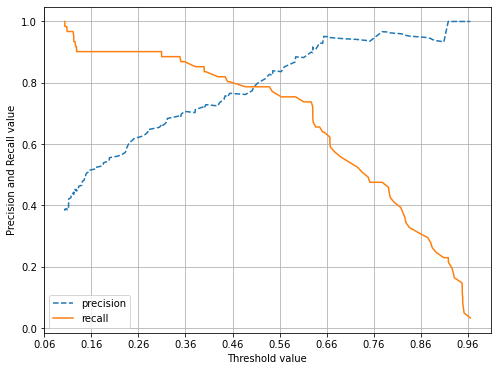

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray ㅜ출
    precisions, recalls, thesholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 정밀도와 재현율의 맹점
: 임곗값의 이러한 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용돼야한다.
- 정밀도와 재현율 성능 수치도 어느 한쪽만 참조하면 극단적인 수치 조작이 가능하다. 따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다.

## 04. F1 스코어
: 정밀도와 재현율을 결합한 지표. 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼때 상대적으로 높은 갑승ㄹ 가진다.
- F1 : 2 x (precision x recall)/(precision + recall)
    - f1_score API 사용

In [56]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [57]:
# 타이타닉 생존자 예측에서 임곗값을 변화시키면서 f1스코어를 포함한 평가 지표 구하기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값:  0.4
오차행렬
 [[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임곗값:  0.45
오차행렬
 [[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값:  0.5
오차행렬
 [[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값:  0.55
오차행렬
 [[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값:  0.6
오차행렬
 [[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


## 05. ROC 곡선과 AUC
- ROC곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이다.
- ROC 곡선
    - 우리말로 수신자 판단 곡선으로 불린다. 의학분야에서 많이 사용되지만, 머신러닝의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표이다.
    - FPR이 변할 떄 TPR이 어떻게 변하는지 나타내는 곡선
        - FPR을 X축, TPR을 Y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.
    - TPR : True Positive Rate 재현율. 민감도로도 불린다.
        - TP /(FN + TP)
        - 실제값 Positive(양성)가 정확히 예측돼야 하는 수준
    - TNR : True Negative Rate 특이성
        - 민감도에 대응하는 지표
        - TN / (FP + TN)
    - FPR : False Positive Rate 
        - FP / (FP + TN) 이므로 1 - TNR 또는 1 - 특이성으로 표현된다.

- ROC 곡선
    - 가운데 직선은 ROC 곡선의 최저 값이다. 왼쪽 하단과 오른쪽 상단을 대각선으로 이은 직선은 동전을 무작위로 던져 앞,뒤를 맞추는 랜덤 수준의 이진 분류의 ROC 직선이다.(AUC는 0.5임)
        - 보통의 분류는 0.5이상의 AUC 값을 가진다.
    - ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것이다.
    - ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 에 따른 TPR값을 구한다.
         - 어떻게 FPR을 0부터 1까지 바꿀까 ?
             - 분류 결정 임곗값을 변경한다.
             - 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이기 때문에 FPR을 0으로 만들려면 임곗값을 1로 지정하면 된다. 반대로 FPR을 1로 만들려면 TN을 0으로 즉, 임곗값을 0으로 지정하면 된다.
   - roc_curve( ) API 
       - 입력 파라미터
           - y_true : 실제 클래스 값 array
           - y_score : preict_proba()의 반환값 array에서 positive 칼럼의 예측확률이 보통 사용된다.
       - 반환 값
           - fpr : fpr값을 array로 반환
           - tpr : tpr값을 array로 반환
           - thresholds : thresold값 array

In [58]:
# 타이타닉 생존자 예측 모델의 FPR, TPR, 임곗값 구하기

from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값은 5 step으로 추출
# thresolds[0]은 max(예측확률) + 1로 임의 설정됨. 이를 제외하기 위해서 np.range는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index: ', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index],2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index:  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


임곗값이 1에 가까운 값에서 점점 작아지면서 FPR값이 점점 커지고, FPR이 조금씩 커질때 TPR은 가파르게 커진다.

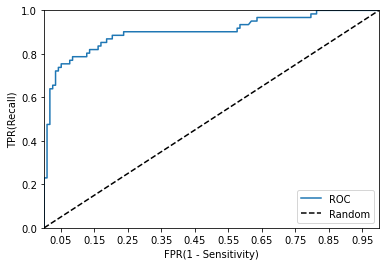

In [59]:
# FPR 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1) :
    # 임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선 그리기
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 scale을 0.1단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

- ROC곡선 자체는 FPR과 TPR의 변화값을 보는데 이용, ROC 곡선 면적에 기반한 AUC값은 분류의 성능 지표로 사용된다.
- AUC(Area Under Curve)값은 ROC곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다.
    - AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건이다.
    - 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적이 1에 가까워지는 좋은 ROC AUC 성능 수치를 얻게 된다.

In [60]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [9]:
# get_clf_eval 함수 업뎃하기
def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_scre(y_test, pred_proba)
    print('오차행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    

## 06. 피마 인디언 당뇨병 예측

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head()

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
# feature 타입과 Null 개수 살펴보기

diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [15]:
# 앞 예제에서 사용한 유틸리티 함수 불러오기 

# 평가 한꺼번에 호출하는 함수
def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 임곗값 하나씩 평가 지표 조사하는 함수
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
# 정밀도와 재현율 곡선 시각화
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thesholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [11]:
# 로지스틱 회귀를 이용한 예측 모델 생성

# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 칼럼으로 레이블 값이다. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
get_clf_eval(y_test, pred, pred_proba)

오차행렬
 [[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC: 0.7919
